In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [77]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g

def gradient_function(actor, critic):
    params = actor.trainable_weights
    # placeholder
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    ts_input = tf.placeholder(tf.float32, shape=(None, 1))
    values_input = tf.placeholder(tf.float32, shape=(None, 1))
    
    # q_func gradient tensor
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    obj1 = tf.multiply(K.exp(- alpha * ts_input), critic_output_tensor)
    loss1 = -K.sum(obj1)
    gradient_for_q = dummy_optimizer.get_gradients(loss1, params)
    
    # discount factor gradient tensor
    discount = tf.expand_dims(- tf.exp(- alpha * actor_output[:,1]), 1)
    weights = tf.multiply(K.exp(- alpha * ts_input), values_input) # param勾配ないならok
    obj2 = tf.multiply(weights, discount)
    loss2 = K.sum(obj2)
    gradient_for_d = dummy_optimizer.get_gradients(loss2, params)
    
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    func = K.function([state_input, ts_input, values_input], gradient_tensor)
    
    return func

def gradient(states, ts, values, gradient_func):
    gradient = gradient_func([states, ts, values])
    return gradient

# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [103]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 10)
    S2 = np.linspace(-7, 7, 10)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, batch_size = 32, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def reshape_data(data, mode=0):
    tmp = []
    for d in data:
        tmp.append(d)
    if mode==0:
        return np.array(tmp).reshape(len(data), 1, d.shape[0])
    else:
        return np.array(tmp).reshape(len(data), d.shape[0])
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 20.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    '''
    pg = 0
    # Q 関数の勾配を計算する
    for x, t in log:
        g = q_gradient([x], actor, critic)
        g = flatten_gradient(g)
        g *= np.exp(- alpha * t)
        pg += g
    '''
    log = np.array(log)
    nvs = []
    #next value
    for i in range(1,len(log)):
        ns = log[i][0]
        na = actor.predict_on_batch(ns.reshape(1,1,2))
        nv = critic.predict_on_batch([na, ns.reshape(1,1,2)])[0]
        nvs.append(nv)

    pg = func([reshape_data(log[:-1,0]), log[:-1,1], nvs])
    return flatten_gradient(pg)

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

def clone_model(model, target_model):
    params = get_nn_params(model)
    target_model = set_nn_params(target_model, params)
    return target_model


# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 30.:
            log.append([x, episode_time])
            break
    return episode_reward


In [82]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
func = gradient_function(actor, critic)

In [101]:
#actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
#critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
actor.load_weights('../saved_agent/learned_self_linear_ideal4_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear_ideal4_critic.h5')
target_actor = clone_model(actor, target_actor)
target_critic = clone_model(critic, target_critic)
lrs = learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001)
opt = Adam_original(lrs)
ev = evaluation(actor)
ev_log = [ev]
print(f'value_function for initial policy = {ev}')
for i in range(1, 100):
    d_train = train_data(actor, noise=True)
    cand, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(10000//(np.sqrt(i))))
    if np.mean(losses) > 1:
        critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)
    else:
        critic = cand
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    ev_log.append(ev)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -6.0381193097333465
1-step
loss of critic is 8.999626159667969, value_fuction V(s) = -5.685615518658383
|g| = 23348.728653853042


KeyboardInterrupt: 

In [104]:
_, losses = td_learning(d_train, actor, critic, target_actor, target_critic, batch_size=64)

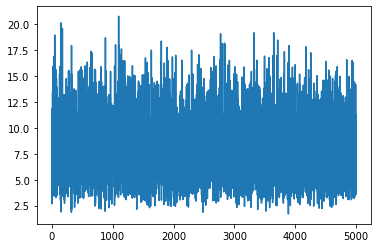

In [105]:
plt.plot(losses)

In [108]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
# actor.load_weights('../saved_agent/mb_self_extend_noisy.h5')
initial_state = np.array([3., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=0.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

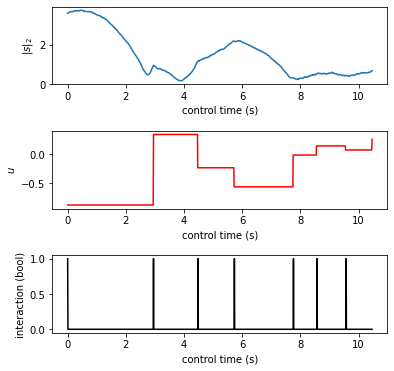

In [109]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

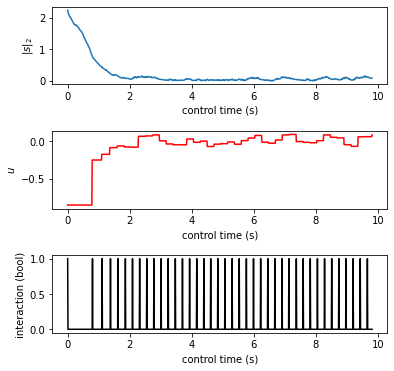

In [11]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [90]:
actor.save_weights('../saved_agent/learned_self_linear_ideal4_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_ideal4_critic.h5')

In [122]:
actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.41994604,  0.4266636 , -0.18461692,  0.16705216, -0.25361168,
        0.34438944,  0.10308936, -0.09404683, -0.1733037 , -0.22091635,
       -0.3533952 ,  0.02600434,  0.5435894 , -0.07042186, -0.3707666 ,
        0.3166266 ], dtype=float32)

In [121]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.42221597,  0.4274628 , -0.18825793,  0.16885139, -0.2542188 ,
        0.34214336,  0.10563881, -0.09488146, -0.17566861, -0.22360145,
       -0.3501546 ,  0.02824089,  0.54246134, -0.07161091, -0.37361035,
        0.31443065], dtype=float32)

In [12]:
%%time
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)

CPU times: user 4.39 s, sys: 151 ms, total: 4.54 s
Wall time: 4.97 s


In [37]:
%%time
# critic用のデータ採り
d_train = train_data(actor, noise=True)

CPU times: user 15.7 s, sys: 158 ms, total: 15.8 s
Wall time: 18.8 s


In [38]:
%%time
critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(5000//np.sqrt(12)))

CPU times: user 4.02 s, sys: 363 ms, total: 4.39 s
Wall time: 3.81 s


In [39]:
%%time
pg = policy_gradient(actor, critic)

CPU times: user 139 ms, sys: 10.1 ms, total: 149 ms
Wall time: 195 ms


In [40]:
%%time
actor = opt.update(actor, pg/np.linalg.norm(pg))

CPU times: user 27.9 ms, sys: 3.98 ms, total: 31.8 ms
Wall time: 86.1 ms


In [41]:
%%time
target_actor = update_target_model(actor, target_actor)
target_critic = update_target_model(critic, target_critic)

CPU times: user 43.2 ms, sys: 4.23 ms, total: 47.4 ms
Wall time: 66.9 ms


In [55]:
sr = '''
value_function for initial policy = -12.800075647708129
1-step
loss of critic is 0.015424109064042568, value_fuction V(s) = -12.736723010163693
|g| = 7164.349073665151
2-step
loss of critic is 0.01477704755961895, value_fuction V(s) = -12.48254152803305
|g| = 5297.679944861314
3-step
loss of critic is 0.02264963649213314, value_fuction V(s) = -12.21382811176683
|g| = 5235.720639432855
4-step
loss of critic is 0.017169812694191933, value_fuction V(s) = -12.120790599200228
|g| = 5936.36286257965
5-step
loss of critic is 0.017549477517604828, value_fuction V(s) = -11.83601598760011
|g| = 9046.94082916582
6-step
loss of critic is 0.021708983927965164, value_fuction V(s) = -11.558982912032171
|g| = 4214.036146748536
7-step
loss of critic is 0.025763191282749176, value_fuction V(s) = -11.278399540683253
|g| = 2750.5312804383625
8-step
loss of critic is 0.032405056059360504, value_fuction V(s) = -9.317611934137668
|g| = 3036.331264452082
9-step
loss of critic is 0.03039749525487423, value_fuction V(s) = -8.948597764561617
|g| = 2088.5369981551517
10-step
loss of critic is 0.03543444350361824, value_fuction V(s) = -8.69070762200949
|g| = 1887.8859525226887
11-step
loss of critic is 0.03854374587535858, value_fuction V(s) = -8.400835895216368
|g| = 3195.348745836551
12-step
loss of critic is 0.04596812278032303, value_fuction V(s) = -8.29900578520755
|g| = 1250.1162494896507
13-step
loss of critic is 0.05473553389310837, value_fuction V(s) = -7.9935850616214355
|g| = 2074.702159810507
14-step
loss of critic is 0.06077631562948227, value_fuction V(s) = -7.734935595903353
|g| = 1890.648226731932
15-step
loss of critic is 0.05458509549498558, value_fuction V(s) = -7.441514578069688
|g| = 1721.615332863787
16-step
loss of critic is 0.06642956286668777, value_fuction V(s) = -7.16520923032851
|g| = 3222.9388280452204
17-step
loss of critic is 0.06386761367321014, value_fuction V(s) = -7.117676876417611
|g| = 2799.492136936748
18-step
loss of critic is 0.08633549511432648, value_fuction V(s) = -7.085221190929554
|g| = 1794.8938381491937
19-step
loss of critic is 0.12490063905715942, value_fuction V(s) = -6.838939717905057
|g| = 2326.862036566345
20-step
loss of critic is 0.1053546741604805, value_fuction V(s) = -6.801252168756537
|g| = 4374.589787327622
21-step
loss of critic is 0.08539760112762451, value_fuction V(s) = -6.570556101435644
|g| = 2854.3117933219282
22-step
loss of critic is 0.08772086352109909, value_fuction V(s) = -6.513037851200342
|g| = 752.6509942115181
23-step
loss of critic is 0.11688154190778732, value_fuction V(s) = -6.264525137393207
|g| = 1469.918087565268
24-step
loss of critic is 0.10778407752513885, value_fuction V(s) = -6.200997588093616
|g| = 1372.15893751489
25-step
loss of critic is 0.14306171238422394, value_fuction V(s) = -5.940358906496612
|g| = 913.7269790705366
26-step
loss of critic is 0.13604968786239624, value_fuction V(s) = -5.937424007946647
|g| = 2104.089925171272
27-step
loss of critic is 0.19308969378471375, value_fuction V(s) = -5.873789628372205
|g| = 1594.2216002533717
28-step
loss of critic is 0.19633795320987701, value_fuction V(s) = -5.612244895266323
|g| = 2648.4663430104306
29-step
loss of critic is 0.45567354559898376, value_fuction V(s) = -5.5689113033656525
|g| = 4196.123121035116
30-step
loss of critic is 0.301399827003479, value_fuction V(s) = -5.534115392725088
|g| = 2943.7651799669457
31-step
loss of critic is 0.47042199969291687, value_fuction V(s) = -5.50917317322002
|g| = 3718.4264480914358
32-step
loss of critic is 0.5888121724128723, value_fuction V(s) = -5.5447222088374915
|g| = 5790.803853576431
33-step
loss of critic is 0.38429445028305054, value_fuction V(s) = -5.513361824395219
|g| = 1784.4000931648247
34-step
loss of critic is 0.6224076151847839, value_fuction V(s) = -5.307543459978506
|g| = 3468.847986791395
35-step
loss of critic is 0.7001288533210754, value_fuction V(s) = -5.2089086379387695
|g| = 2728.8105599499486
36-step
loss of critic is 0.8494100570678711, value_fuction V(s) = -4.969454113826584
|g| = 2715.0446335173565
37-step
loss of critic is 0.7736462354660034, value_fuction V(s) = -4.897991626603423
|g| = 3755.0545172925263
38-step
loss of critic is 0.69222092628479, value_fuction V(s) = -5.7814987094922
|g| = 3252.15664247517
39-step
loss of critic is 0.7046676874160767, value_fuction V(s) = -4.844549540368926
'''

In [56]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

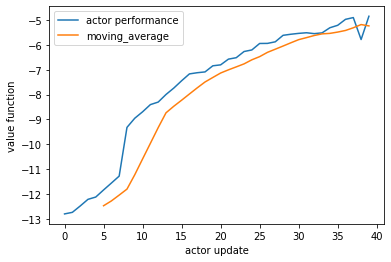

In [57]:
#rs = rs[15:]
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()

In [66]:
opt.lrs * opt.m / (np.sqrt(opt.v) + opt.epsilon)

array([ 3.09227158e-05, -3.16093290e-05, -9.68999418e-06, -4.90697333e-05,
       -2.74005302e-06, -5.07232525e-05, -4.52189392e-05,  1.65770259e-05,
        3.84552062e-05,  4.62917181e-05, -6.10945575e-06, -2.70734791e-05,
        2.01107331e-05, -2.94887914e-05, -6.86215519e-06,  1.89668739e-05,
        2.04582817e-05, -3.16093290e-05,  1.74450700e-05, -2.78466429e-05,
        9.12578110e-06, -4.41808301e-05, -4.82113844e-05,  1.23784771e-05,
       -2.12101955e-05,  5.38291432e-05, -9.09675660e-06, -7.18798229e-06,
       -1.95929580e-05, -2.54708620e-05, -1.40366063e-05,  3.11088650e-05,
       -4.14143365e-05,  3.15288829e-05, -3.69675121e-05, -2.04987514e-05,
        1.81981329e-05,  1.66245397e-05,  4.05792155e-05, -8.84054617e-06,
        2.88379056e-05, -3.72390448e-05,  3.29463587e-05, -3.05362188e-05,
        1.65504404e-05,  2.84074342e-05, -2.09826823e-05,  8.17866212e-06,
        3.59536986e-04, -1.12473195e-04,  1.65731401e-04, -2.24322964e-04,
       -1.34577459e-04,  